In [43]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
import scienceplots
import pandas as pd
import pickle

from src import CARPoolSimulations
from src import CARPoolEmulator

In [2]:
def extract_params(line):
    params = line.split(' ')[1:29]
    params.append(line.split(' ')[35])
    return np.array(params, dtype='float')
def BS_organizer(N, thetas):
    theta_S = []
    theta_B = []
    for i, theta in zip(N, thetas):
        if (i//128)%2 ==0:
            theta_B.append(theta)
        elif (i//128)%2 ==1:
            theta_S.append(theta)
        else:
            raise Exception("Somethings totally wrong")
    return np.array(theta_B), np.array(theta_S)
    
def BS_matcher(N_B, N_S, base, surrogate):
    bases, surrogates = [], []
    #match bases with surrogates
    for i, b in enumerate(N_B):
        if b+128 in N_S:
            bases.append(i)
            j = np.where(b+128 == N_S)[0][0]
            surrogates.append(j)
    #create list of bases and surrogates, non-pairs at the end
    if len(bases) > 0 and len(surrogates) > 0:
        base = np.concatenate((base[np.array(bases)], base[np.delete(np.arange(len(base)), bases)]))
        surrogate = np.concatenate((surrogate[np.array(surrogates)], surrogate[np.delete(np.arange(len(surrogate)), surrogates)]))
    return base, surrogate

In [3]:
LR       = 1e-5

with open('Data/PARAMS.txt', 'r') as file:
    lines = file.readlines()
theta_raw = np.array([extract_params(line) for line in lines])
theta = theta_raw.copy()
param_info = pd.read_csv('Data/SB28_param_minmax.csv')
#Normalize parameters
for i, t in enumerate(theta_raw[:, :-1].T):
    if bool(param_info['LogFlag'][i]):
        theta[:, i] = np.log10(theta_raw[:, i])




In [4]:
file = open('quenched_fraction_zoom10.txt','r')
lines = file.readlines()

In [7]:
emu_list = []
theta_min = np.array(param_info['MinVal']).astype('float')
theta_max = np.array(param_info['MaxVal']).astype('float')

theta_min = np.append(theta_min,12)
theta_max = np.append(theta_max,15)

for i in range(len(theta_min)-1):
    if bool(param_info['LogFlag'][i]):
        theta_min[i] = np.log10(theta_min[i])
        theta_max[i] = np.log10(theta_max[i])

mass_bin = 0
    
data = np.array([float(line.split()[mass_bin+3]) for line in lines])

usable_indices = np.isnan(data)

quenched = data[usable_indices]
halo_masses = np.log10(np.array([float(line.split()[1]) for line in lines])[usable_indices])
zoom_num = np.array([int(line.split()[0]) for line in lines])[usable_indices]

usable_theta = theta[zoom_num]
usable_theta[:,-1] = halo_masses
usable_theta_normalized = (usable_theta - theta_min) / (theta_min - theta_max) + 1

theta_B, theta_S  = BS_organizer(zoom_num, usable_theta_normalized)
Q_B, Q_S          = BS_organizer(zoom_num, quenched) 
N_B, N_S          = BS_organizer(zoom_num,zoom_num)

Q_B, Q_S          = BS_matcher(N_B, N_S, Q_B, Q_S)
theta_B, theta_S  = BS_matcher(N_B, N_S, theta_B, theta_S)

# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_B  ;  sims.quantities  = Q_B
surrs.parameters = theta_S  ;  surrs.quantities = Q_S
    

output = 

#Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) 
emu = CARPoolEmulator.Emulator(sims, surrs)
params = {"scaleV"   :np.random.normal(.5,.1,emu.param_dimensions),
        "scaleX" :np.random.normal(.5,.1,emu.param_dimensions),
        "scaleW" :np.random.normal(.5,.1,emu.param_dimensions),
        "scaleM" :np.random.normal(.5,.1,emu.param_dimensions),
        "log_ampV"   :0.0*np.ones(emu.param_dimensions),
        "log_ampW"   :0.0*np.ones(emu.param_dimensions),
        "log_ampX"   :0.0*np.ones(emu.param_dimensions),                
        "log_deltaP" :0*np.ones(emu.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
line = ''

best_params = emu.train(params,learning_rate=LR, max_iterations=10000)
evo = emu.param_evolution
line = ''

with open('evolution.txt','w') as output:
    

In [8]:
param_info = pd.read_csv('Data/SB28_param_minmax.csv')
hp_test = open('hp_test2.txt','r')
lines = hp_test.readlines()

start_scales = [[] for i in range(len(lines)//2)]
end_scales = [[] for i in range(len(lines)//2)]
for run in range(len(lines)//2):
    data = [float(x) for x in lines[2*run].split()]
    start_scales[run].append(data[7:36])
    start_scales[run].append(data[36:65])
    start_scales[run].append(data[65:94])
    start_scales[run].append(data[94:123])

    end_data = [float(x) for x in lines[2*run+1].split()]
    end_scales[run].append(end_data[7:36])
    end_scales[run].append(end_data[36:65])
    end_scales[run].append(end_data[65:94])
    end_scales[run].append(end_data[94:123])

start_scales = np.array(start_scales)
end_scales = np.array(end_scales)

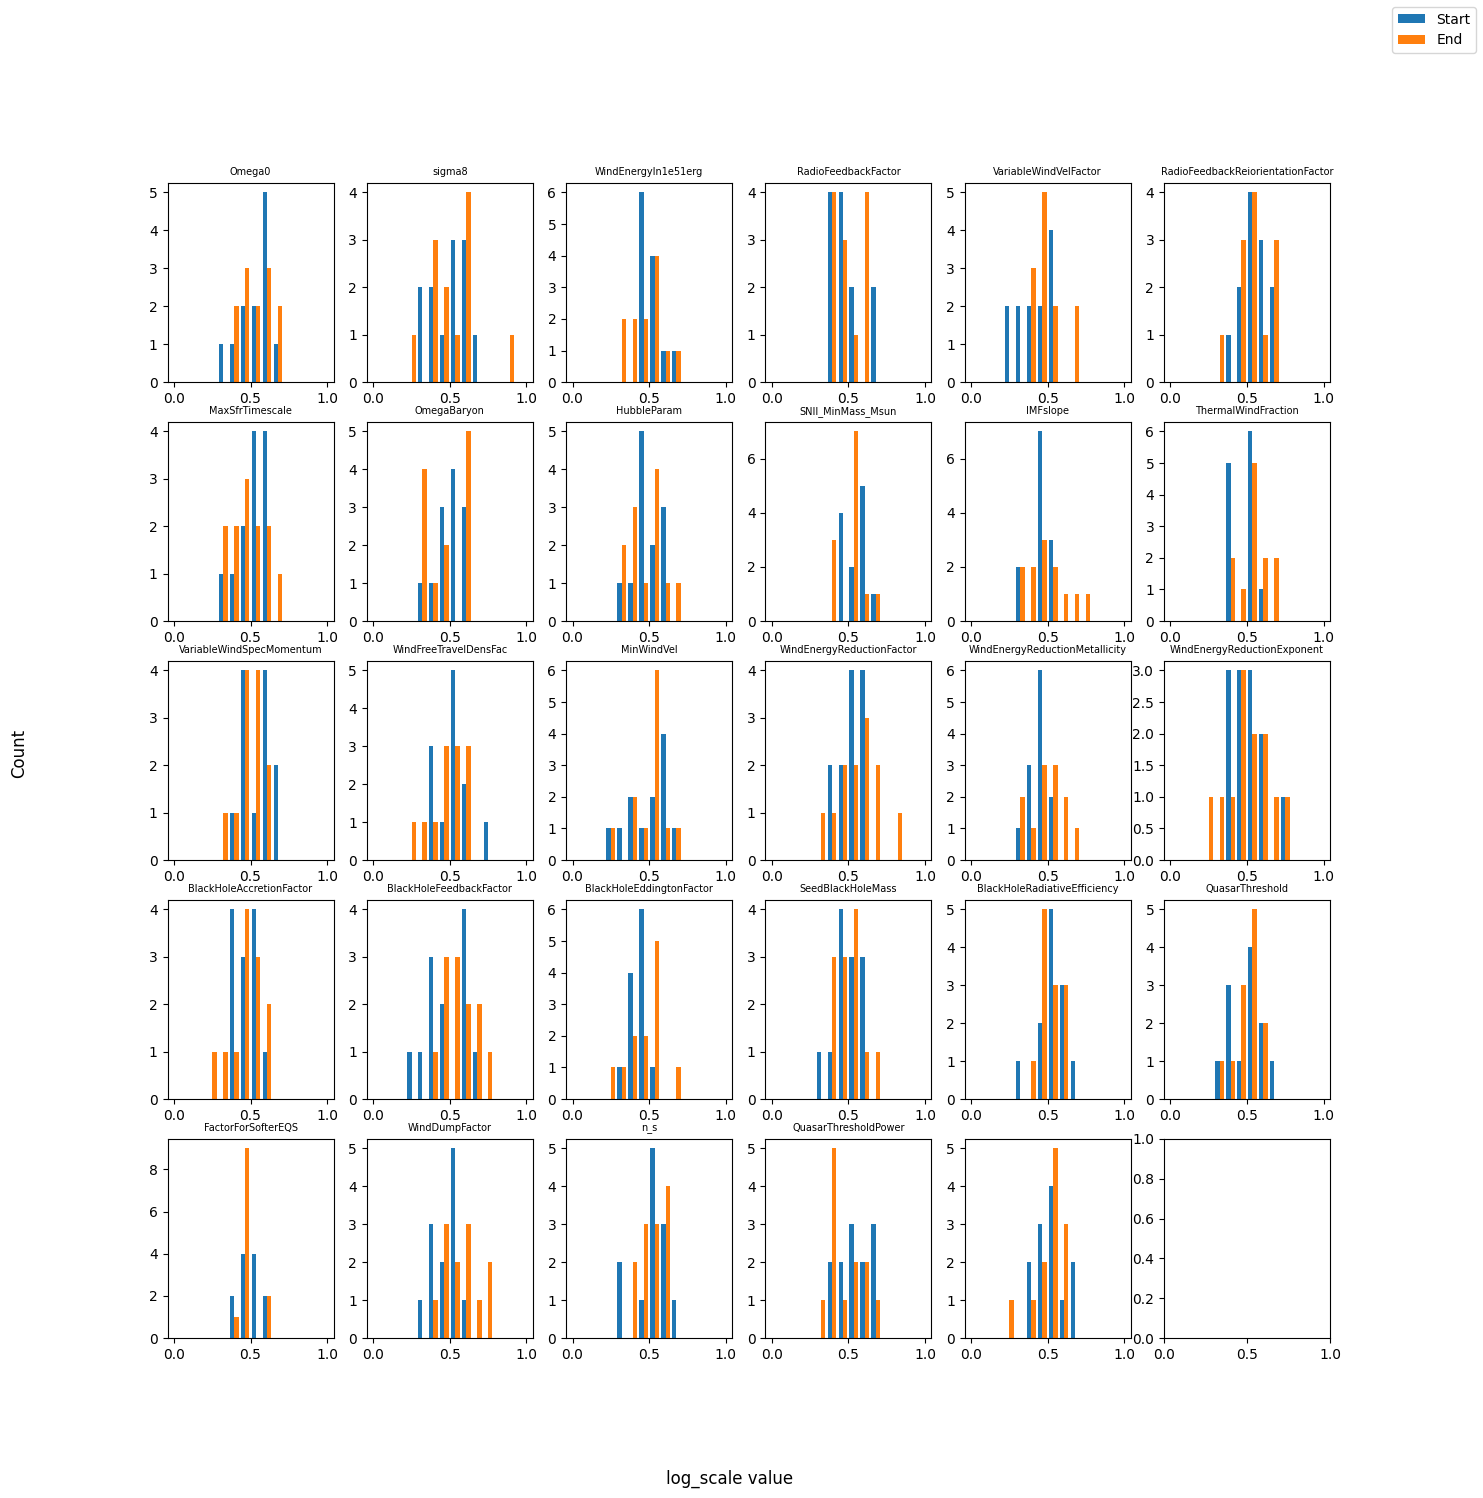

In [10]:
fig, ax = plt.subplots(5,6,figsize=(15,15))
n = 0

for row in range(5):
    for column in range(6):
        value = 6*row+column
        if value == 29:
            break
        if value != 28:
            ax[row,column].set_title(param_info['ParamName'][value],fontsize=7)
        ax[row,column].hist([start_scales[:,n,value].flatten(),end_scales[:,n,value].flatten()], bins=np.linspace(-0,1,15))
        

fig.supylabel("Count")
fig.supxlabel("log_scale value")
fig.legend(['Start','End'])

Text(0, 0.5, 'Loss')

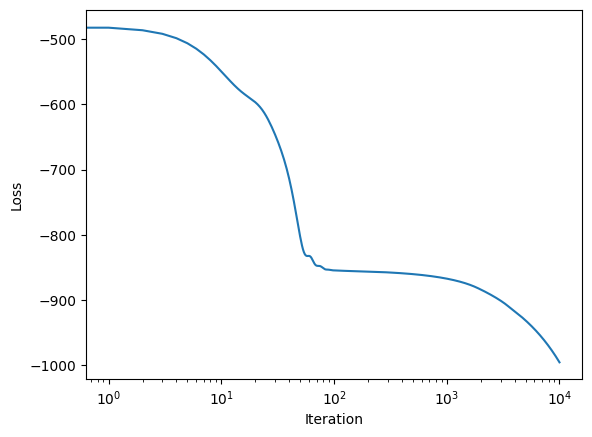

In [11]:
plt.semilogx(emu.losses[-1])
plt.xlabel('Iteration')
plt.ylabel('Loss')

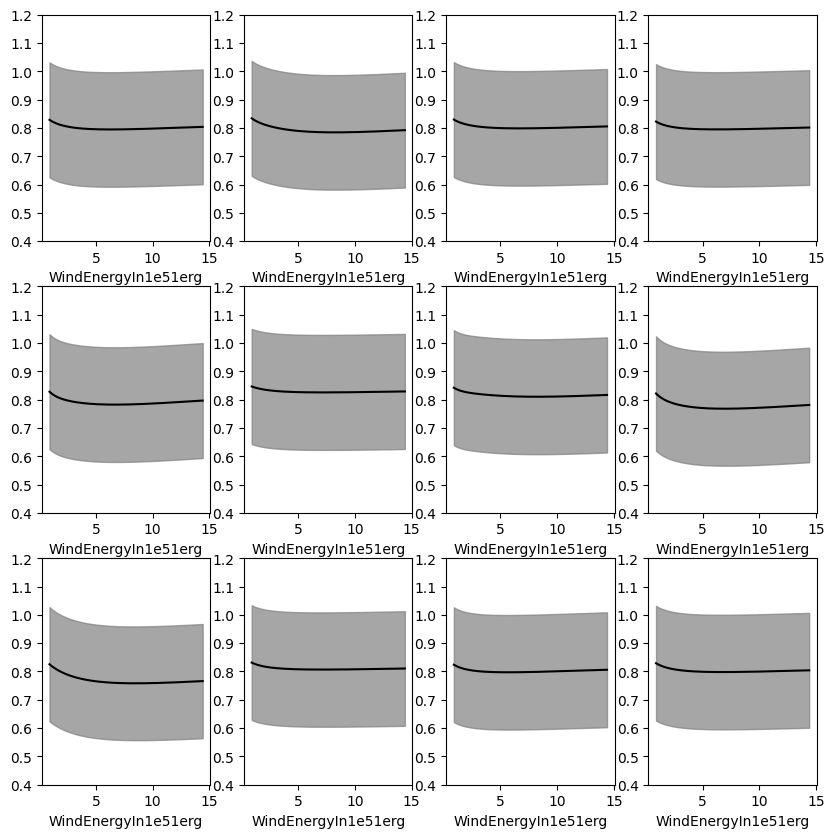

In [41]:
P = 2
fig, ax = plt.subplots(3,4,figsize=(10,10))

for row in range(3):
    for column in range(4):
        n = 4*row + column
        emu.params['scaleV'] = end_scales[n,0]
        emu.params['scaleX'] = end_scales[n,1]
        emu.params['scaleW'] = end_scales[n,2]
        emu.params['scaleM'] = end_scales[n,3]
        
        
        theta_test = np.ones((1000, 29)) * 0.5
        theta_test[:, P] = np.linspace(0, 1, 1000)
        pred_mean, pred_var = emu.predict(theta_test)
        
        # Put the parameter back into physical units
        x = (theta_test[:, P] - 1) * (theta_min[P] - theta_max[P]) + theta_min[P]
        if P<28:
            if bool(param_info['LogFlag'][P]) == True:
                x = 10**x
        
        ax[row,column].plot(x, pred_mean, color='k')
        ax[row,column].set_ylim(.4,1.2)
        std = np.diag(pred_var)**(0.5)
        ax[row,column].fill_between(x, pred_mean-std, pred_mean + std, color='grey', alpha=0.7)
        if P<28:
            ax[row,column].set_xlabel(param_info['ParamName'][P])
        else:
            ax[row,column].set_xlabel('Mass')

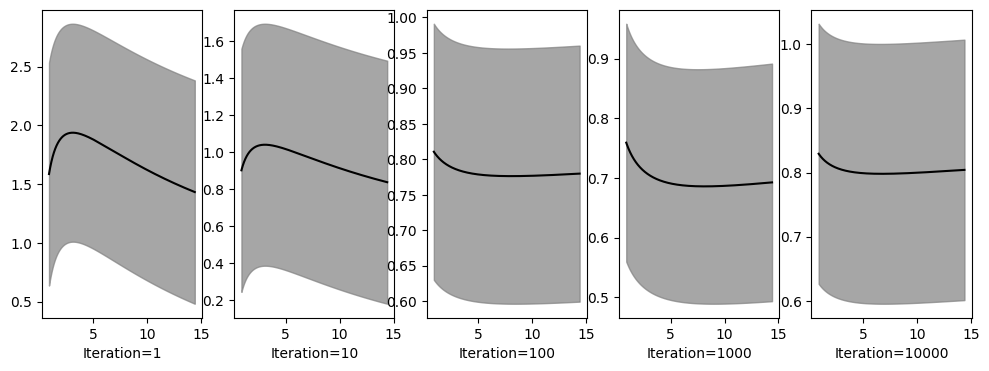

In [53]:
P = 2
fig, ax = plt.subplots(1,5,figsize=(12,4))

checkpoints = [1,10,100,1000,10000]

for i in range(5):
    emu.params = evo[checkpoints[i]-1]
    
    theta_test = np.ones((1000, 29)) * 0.5
    theta_test[:, P] = np.linspace(0, 1, 1000)
    pred_mean, pred_var = emu.predict(theta_test)
    
    # Put the parameter back into physical units
    x = (theta_test[:, P] - 1) * (theta_min[P] - theta_max[P]) + theta_min[P]
    if P<28:
        if bool(param_info['LogFlag'][P]) == True:
            x = 10**x
    
    ax[i].plot(x, pred_mean, color='k')
    #ax[i].set_ylim(.4,1.2)
    std = np.diag(pred_var)**(0.5)
    ax[i].fill_between(x, pred_mean-std, pred_mean + std, color='grey', alpha=0.7)
    if P<28:
        ax[i].set_xlabel("Iteration="+str(checkpoints[i]))
    else:
        ax[row,column].set_xlabel('Mass')